### Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot

# Estilos de Seaborn
sns.set()
sns.set_palette(palette='colorblind')

### Carga de datos

In [27]:
columnas_cargar = [ "created","application_id", "ref_type", "attributed", "implicit",
                   "device_brand", "event_uuid", "kind", "wifi", 'ref_hash']

installs = pd.read_csv("../../../data/installs.csv", usecols=columnas_cargar, parse_dates=["created"])

columnas_cargar = ['event_uuid', 'attributed', 'kind']

eventos = pd.read_csv('../../../data/events.csv', usecols=columnas_cargar)

eventos= eventos.rename(columns = {"attributed": "attributed_evento", 'kind': 'kind_evento'})

columnas_cargar = ['created', 'touchX', 'touchY', 'ref_hash']

clicks = pd.read_csv('../../../data/clicks.csv', usecols = columnas_cargar, parse_dates=["created"])



In [4]:
installs.dtypes

created           datetime64[ns]
application_id             int64
ref_type                   int64
ref_hash                   int64
attributed                  bool
implicit                    bool
device_brand             float64
event_uuid                object
kind                      object
wifi                      object
dtype: object

# Preguntas:

## Cuántos installs hubieron? 

In [5]:
installs.ref_hash.count()

3412

## Cuántos fueron atribuidos a Jampp?

In [6]:
installs[installs["attributed"]].ref_hash.count()

0

# Análisis de Installs en el tiempo

### Cómo evolucionaron los installs en el mes?

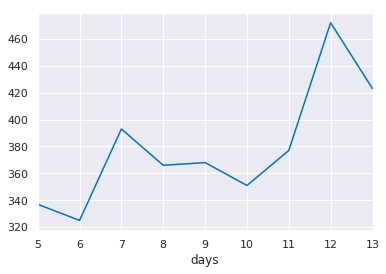

In [7]:
# add a column hours and days
installs["hours"] = installs['created'].dt.hour
installs["days"] = installs['created'].dt.day

installs_por_dia = installs.groupby(installs['days']).ref_hash.agg("count").rename(columns ={"ref_hash":"Cantidad de Installs"})
    
grafico = installs_por_dia.plot(kind="line")


In [8]:
(installs[installs['created'].dt.day == 12])['created'].dt.day_name().iloc[0]

'Tuesday'

### Cómo evolucionaron los installs según la hora del día?

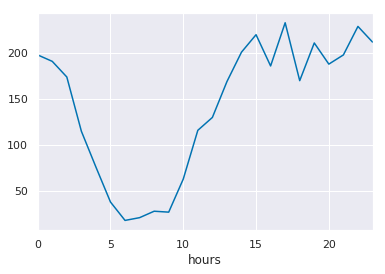

In [9]:
installs_por_hora = installs.groupby(installs['hours']).ref_hash.agg("count").rename(columns ={"ref_hash":"Cantidad de Installs"})
    
grafico = installs_por_hora.plot(kind="line")


Text(111.5, 0.5, 'Cantidad de Installs')

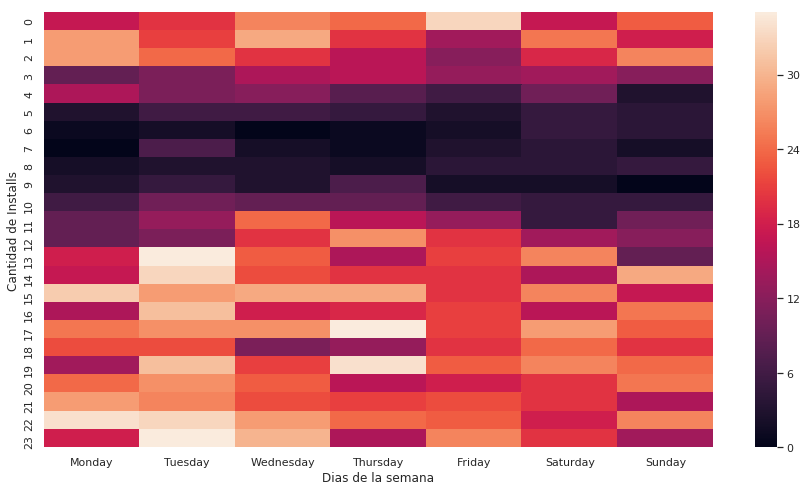

In [10]:
installs["day_of_week"] = installs["created"].dt.day_name()
install_count = installs[(installs["created"] >= "03-07-2019")]\
                .groupby( [pd.Grouper(key="created",freq="h"),"day_of_week" ])["ref_hash"].count().reset_index()
intalls_por_dia_hora = install_count.pivot("created","day_of_week","ref_hash").reset_index()
intalls_por_dia_hora["created"] = intalls_por_dia_hora["created"].dt.hour  
intalls_por_dia_hora = intalls_por_dia_hora.groupby("created").agg("sum")
column_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
intalls_por_dia_hora = intalls_por_dia_hora.reindex(column_order, axis=1)

fig,ax = plt.subplots(figsize = (15,8))
sns.heatmap(intalls_por_dia_hora)
ax.set_xlabel("Dias de la semana")
ax.set_ylabel("Cantidad de Installs")


# Análisis de Installs en el por marcas

### Cuáles marcas tuvieron más installs?

In [11]:
installs_por_marca = installs.groupby(installs['device_brand']).agg({"ref_hash" : "count"}) 
otros = installs_por_marca[installs_por_marca['ref_hash'] < 100]
installs_por_marca = installs_por_marca[installs_por_marca['ref_hash'] >= 100].reset_index()


In [12]:
adjuntar = pd.DataFrame([['Other', otros.ref_hash.sum()]])
adjuntar.columns = ['device_brand','ref_hash']

installs_por_marca =installs_por_marca.append(adjuntar)
installs_por_marca = installs_por_marca.rename(columns = {"ref_hash": "cantidad_de_instalaciones"})

Text(0.5, 0, 'Marca')

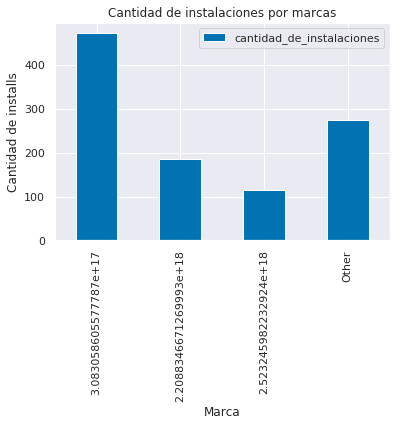

In [13]:
installs_por_marca.plot(x='device_brand', y='cantidad_de_instalaciones',kind="bar")
plt.title("Cantidad de instalaciones por marcas")
plt.ylabel("Cantidad de installs")
plt.xlabel("Marca")


# Análisis de Installs y WIFI


### Installs con WIFI ?

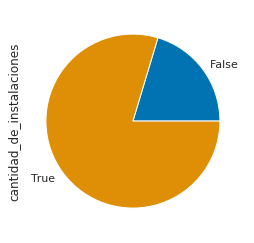

In [14]:
install_con_wifi = installs.rename(columns = {"ref_hash": "cantidad_de_instalaciones"})
install_con_wifi.groupby(install_con_wifi['wifi']).cantidad_de_instalaciones.count().plot.pie()


In [15]:
install_con_wifi.groupby(install_con_wifi['wifi']).cantidad_de_instalaciones.count()

wifi
False     352
True     1377
Name: cantidad_de_instalaciones, dtype: int64

# Eventos y Installs

### Eventos anteriores al install

In [16]:
install_evento = pd.merge(installs.dropna(subset=['event_uuid']), eventos , how='inner', on='event_uuid')

In [17]:
install_evento_ant = install_evento.groupby(install_evento['kind_evento']).agg({"ref_hash" : "count"}) 

otros = install_evento_ant[install_evento_ant['ref_hash'] < 10]
install_evento_ant = install_evento_ant[install_evento_ant['ref_hash'] >= 10].reset_index()


In [18]:
adjuntar = pd.DataFrame([['Other', otros.ref_hash.sum()]])
adjuntar.columns = ['kind_evento','ref_hash']

install_evento_ant =install_evento_ant.append(adjuntar)
install_evento_ant = install_evento_ant.rename(columns = {"ref_hash": "cantidad_de_instalaciones_por_evento"})

Text(0.5, 0, 'Evento')

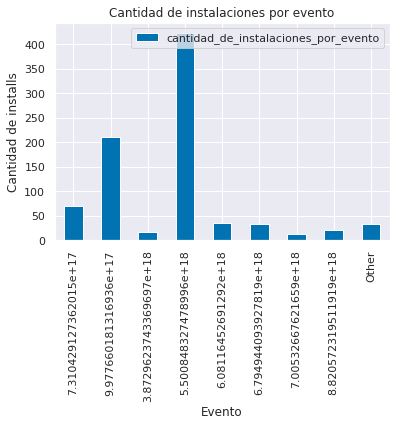

In [19]:
install_evento_ant.plot(x='kind_evento', y='cantidad_de_instalaciones_por_evento',kind="bar")
plt.title("Cantidad de instalaciones por evento")
plt.ylabel("Cantidad de installs")
plt.xlabel("Evento")


In [20]:
install_evento.head()

,created,application_id,ref_type,ref_hash,attributed,implicit,device_brand,event_uuid,kind,wifi,hours,days,day_of_week,attributed_evento,kind_evento
0,2019-03-13 04:20:57.666,0,1891515180541284343,7953318831018100268,False,True,5.137992e+17,0bfa9b4c-e07a-4522-b32d-138e3165ac98,Open,NaN,4,13,Wednesday,False,8.820572e+18
1,2019-03-10 22:24:56.684,0,1891515180541284343,8355110941557237501,False,True,1.083369e+18,8f235a8c-41bf-4399-b33d-c41577c949b0,Open,NaN,22,10,Sunday,False,8.820572e+18
2,2019-03-11 03:47:22.802,0,1891515180541284343,4306303321567254439,False,True,3.083059e+17,b3f7905b-5058-4eca-853c-b3c670d7ac54,Open,NaN,3,11,Monday,False,8.820572e+18
3,2019-03-11 21:21:05.855,0,1891515180541284343,1670430602051291592,False,True,1.083369e+18,28a6e6a0-ba70-46a2-a63f-1e74b0dd5235,Open,NaN,21,11,Monday,False,8.820572e+18
4,2019-03-13 11:36:30.025,2,1891515180541284343,5716316704073038128,False,True,2.987569e+18,5e8458cb-787c-448c-8836-2e808dbc2c15,open,True,11,13,Wednesday,False,6.081165e+18


# Aplicaciones e Installs
## Aplicaciones con más installs

Text(0.5, 0, 'Aplicación')

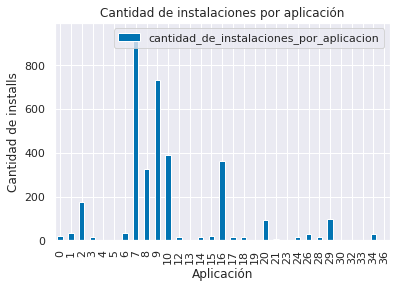

In [26]:
aplicaciones_con_mas_installs = installs.groupby(installs['application_id']).agg({"ref_hash" : "count"}).reset_index()
aplicaciones_con_mas_installs = aplicaciones_con_mas_installs.rename(columns = {"ref_hash": "cantidad_de_instalaciones_por_aplicacion"})
aplicaciones_con_mas_installs.plot( x= 'application_id',  y='cantidad_de_instalaciones_por_aplicacion', kind="bar")
plt.title("Cantidad de instalaciones por aplicación")
plt.ylabel("Cantidad de installs")
plt.xlabel("Aplicación")


# Clicks es installs

## Clicks correspondientes a installs

In [50]:
install_click = pd.merge(installs.dropna(subset=['ref_hash']), clicks , how='inner', on='ref_hash')
install_click = install_click.rename(columns = {'created_y': 'created_click'})
install_click['created_click'] = install_click['created_click'].dt.tz_convert(None)
install_click = install_click.rename(columns = {'created_x': 'created_install'})
install_click[install_click['created_install'].dt.date == (install_click['created_click'].dt.date) ]



,created_install,application_id,ref_type,ref_hash,attributed,implicit,device_brand,event_uuid,kind,wifi,created_click,touchX,touchY
10,2019-03-10 08:30:15.346,7,1891515180541284343,2369915544093215150,False,False,NaN,NaN,NaN,NaN,2019-03-10 10:29:19.742,0.308,0.879
